<a href="https://colab.research.google.com/github/rahiakela/practical-machine-learning-with-tensorflow/blob/week-5/assignment_5_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Using Pretrained ConvNets

You will follow the general machine learning workflow.

* 1 Examine and understand the data
* 2 Build an input pipeline
* 3 Compose our model
  * Part-1: Load in our pretrained base model (and pretrained weights)
  * Part-2: Stack our classification layers on top
* 4 Train our model
* 5 Evaluate model

## Import and Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


## Data preprocessing

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),                                         
                                                            as_supervised=True)

print(raw_train)
print(raw_validation)
print(raw_test)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Show the first two images and labels from the training set:

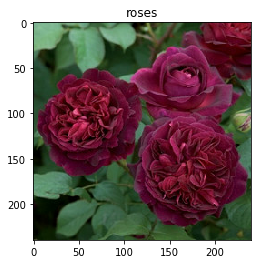

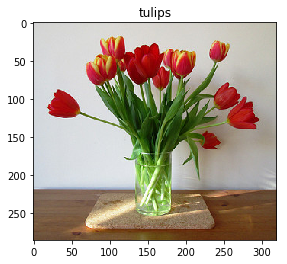

In [5]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Format the Data

In [0]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  print('Before resizing: ', image.shape)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  print('Afetr resizing: ', image.shape)
  return image, label

Apply this function to each item in the dataset using the map method:

In [7]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print('Training set shape: ', train.batch)
print('Vaidation set shape: ', validation.batch)
print('Testing set shape: ', test.batch)

Before resizing:  (None, None, 3)
Afetr resizing:  (160, 160, 3)
Before resizing:  (None, None, 3)
Afetr resizing:  (160, 160, 3)
Before resizing:  (None, None, 3)
Afetr resizing:  (160, 160, 3)
Training set shape:  <bound method DatasetV2.batch of <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>>
Vaidation set shape:  <bound method DatasetV2.batch of <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>>
Testing set shape:  <bound method DatasetV2.batch of <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>>


Now shuffle and batch the data.

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

#### Q5 What is the shape of one batch of data?

In [10]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## 1. Create the base model from the pre-trained convnets

You will create the base model from the Inception V3 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This model has already learned the basic features that are common in 1000 objects that we see daily. Hence, it has a strong feature extraction capability. We download a network that doesn’t include the classification layers at the top, by specifying include_top=False argument, because we only want to use the feature extraction portion of these pre-trained convnets (convolutional base)

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model Inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87916544/87910968 [==============================] - 8s 0us/step


### Q6 What is the shape of a new block of features converted by the feature extractor?

In [12]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [13]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Feature extraction

### Freeze the convolutional base

In [19]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add a classification head

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [21]:
prediction_layer = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


Now stack the feature extractor, and these two layers using a tf.keras.Sequential model:

In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer                    
])

### Compile the model

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Q7 What is the total number trainable TF variables in the model?

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
len(model.trainable_variables)

2

### Q8 What is the total numebr of Trainable parameters in this model?

### Train the model

In [26]:
history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

Epoch 1/10
93/93 [==============================] - 28s 304ms/step - loss: 1.2399 - accuracy: 0.5051 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
93/93 [==============================] - 18s 195ms/step - loss: 0.8430 - accuracy: 0.7054 - val_loss: 1.9376 - val_accuracy: 0.5472
Epoch 3/10
93/93 [==============================] - 18s 196ms/step - loss: 0.7319 - accuracy: 0.7458 - val_loss: 2.1135 - val_accuracy: 0.5833
Epoch 4/10
93/93 [==============================] - 18s 193ms/step - loss: 0.6706 - accuracy: 0.7678 - val_loss: 1.8303 - val_accuracy: 0.6361
Epoch 5/10
93/93 [==============================] - 18s 196ms/step - loss: 0.6398 - accuracy: 0.7675 - val_loss: 1.8073 - val_accuracy: 0.6639
Epoch 6/10
93/93 [==============================] - 19s 202ms/step - loss: 0.6010 - accuracy: 0.7919 - val_loss: 2.3133 - val_accuracy: 0.6083
Epoch 7/10
93/93 [==============================] - 18s 195ms/step - loss: 0.5746 - accuracy: 0.8024 - val_loss: 2.4064 - val_accuracy

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Learning curves

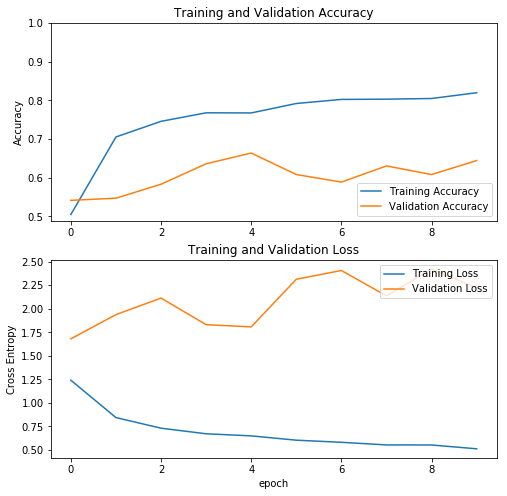

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 2. Fine tuning

### Un-freeze the top layers of the model

In [0]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print('Number of layers in the base model: ', len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


### Q9 What is the total number trainable TF variables in the model?

### Compile the model

In [0]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
len(model.trainable_variables)

37

### Q10 What is the total numebr of Trainable parameters in this model now?

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,551,685
Non-trainable params: 11,261,344
_________________________________________________________________


### Continue Train the model

In [40]:
initial_epochs=10
total_epochs = initial_epochs + 10

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
93/93 [==============================] - 29s 317ms/step - loss: 0.6554 - accuracy: 0.7841 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/20
93/93 [==============================] - 21s 226ms/step - loss: 0.2651 - accuracy: 0.9095 - val_loss: 1.5517 - val_accuracy: 0.7306
Epoch 13/20
93/93 [==============================] - 21s 225ms/step - loss: 0.1923 - accuracy: 0.9403 - val_loss: 2.0259 - val_accuracy: 0.7194
Epoch 14/20
93/93 [==============================] - 21s 222ms/step - loss: 0.1007 - accuracy: 0.9664 - val_loss: 1.7594 - val_accuracy: 0.7556
Epoch 15/20
93/93 [==============================] - 21s 225ms/step - loss: 0.1218 - accuracy: 0.9590 - val_loss: 1.4720 - val_accuracy: 0.7833
Epoch 16/20
93/93 [==============================] - 21s 223ms/step - loss: 0.1084 - accuracy: 0.9664 - val_loss: 1.7605 - val_accuracy: 0.7444
Epoch 17/20
93/93 [==============================] - 20s 218ms/step - loss: 0.1281 - accuracy: 0.9580 - val_loss: 1.6790 - val_a

### Q11 Let the training accuracy in part-1 be x and training accuracy in part-2 be y (both after training is done). The value of | y-x | lies between?

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

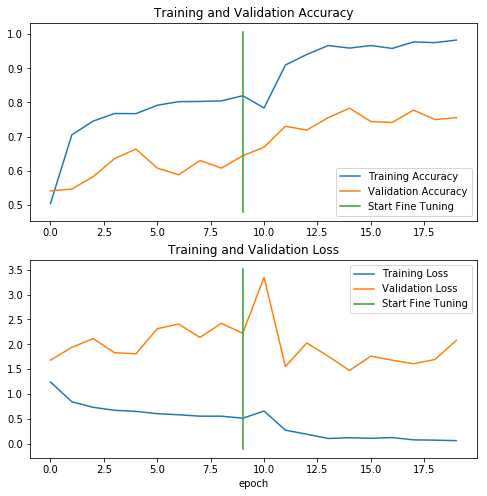

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [69]:
import numpy as np
from scipy import stats

x_acc = history.history['accuracy']
y_acc = history_fine.history['accuracy']

print('Accuracy before tuning: ', sorted(x_acc))
print('Accuracy after tuning: ', sorted(y_acc))
print(len(x_acc))
print(len(y_acc))

for i in range(len(sorted(y_acc))):
  print(y_acc[i] - x_acc[i])

for i in range(len(sorted(x_acc[10:]))):
  print(y_acc[i] - x_acc[i])  

Accuracy before tuning:  [0.50508475, 0.7054237, 0.7457627, 0.7674576, 0.76779664, 0.7840678, 0.7918644, 0.8023729, 0.8030509, 0.80474573, 0.819661, 0.90949154, 0.94033897, 0.9579661, 0.95898306, 0.9664407, 0.9664407, 0.97491527, 0.97694916, 0.9823729]
Accuracy after tuning:  [0.7840678, 0.90949154, 0.94033897, 0.9579661, 0.95898306, 0.9664407, 0.9664407, 0.97491527, 0.97694916, 0.9823729]
20
10
0.27898306
0.20406783
0.19457626
0.19864404
0.19152546
0.17457628
0.15559322
0.17389828
0.17016953
0.16271186
0.27898306
0.20406783
0.19457626
0.19864404
0.19152546
0.17457628
0.15559322
0.17389828
0.17016953
0.16271186


In [64]:
stats.mode(y_acc)

ModeResult(mode=array([0.9664407], dtype=float32), count=array([2]))